In [163]:
from sfa import SparseFactorAnalyzer
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn import metrics
from scipy.spatial import distance
from sklearn import metrics

In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
data_path = 'data/variance_stabilized.csv'
pheno_path = 'data/phenotype.csv'
data = pd.read_csv(data_path, index_col=0)
phenotype = pd.read_csv(pheno_path, index_col=0)

small_data = data.loc[data.var(axis=1).nlargest(10000).index]
small_data = data.loc[small_data.var(axis=1).nsmallest(9500).index]

val_index = np.random.choice(9500, 1000, replace=False)
cross_val_data = small_data.iloc[val_index]

train_index = np.random.choice(8500, 3000, replace=False)
train_data = small_data.drop(cross_val_data.index)
train_data = train_data.iloc[train_index]

In [148]:
sfa1 = pickle.load(open('output/sfa1', 'rb'))
sfa2 = pickle.load(open('output/sfa2', 'rb'))
sfa3 = pickle.load(open('output/sfa3', 'rb'))

ssfa1 = pickle.load(open('output/ssfa1', 'rb'))
ssfa2 = pickle.load(open('output/ssfa2', 'rb'))
ssfa3 = pickle.load(open('output/ssfa3', 'rb'))

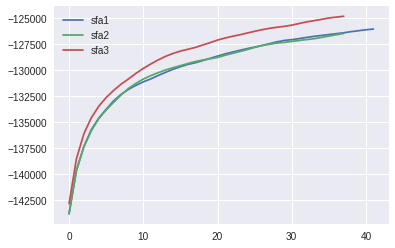

In [149]:
plt.plot(sfa1.lls[3:], label='sfa1')
plt.plot(sfa2.lls[3:], label='sfa2')
plt.plot(sfa3.lls[3:], label='sfa3')
plt.legend()

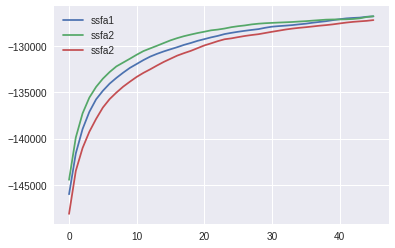

In [150]:
plt.plot(ssfa1.lls[3:], label='ssfa1')
plt.plot(ssfa2.lls[3:], label='ssfa2')
plt.plot(ssfa3.lls[3:], label='ssfa2')
plt.legend()

In [35]:
def residual_variance(sfa, data):
    return np.var(data.as_matrix() - np.dot(sfa.Lambda, sfa.F))

In [161]:
def make_clustering(sfa):
    """
    makes a clustering from the loadings by placing a gene the cluster K
    corresponding to the component with greatest magnitude
    """
    return np.abs(sfa.Lambda).argmax(axis=1)

In [157]:
X = pd.DataFrame(data=sfa2.F.T, index=phenotype.index)
X['DAY'] = phenotype.DAY
X = X.sort_values('DAY')
X.drop('DAY', axis=1, inplace=True)

Y = pd.DataFrame(data=ssfa3.F.T, index=phenotype.index)
Y['DAY'] = phenotype.DAY
Y = Y.sort_values('DAY')
Y.drop('DAY', axis=1, inplace=True)

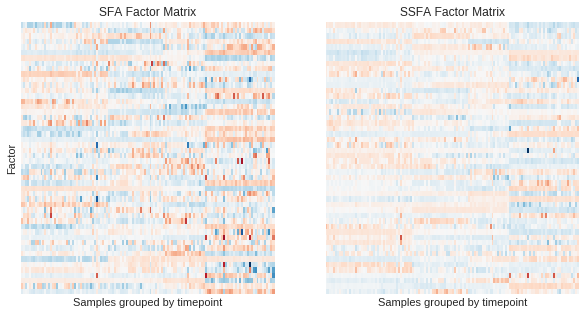

In [160]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.heatmap((X - X.mean(axis=0)).T, cbar=False, ax=ax[0], xticklabels=False, yticklabels=False)
sns.heatmap((Y - Y.mean(axis=0)).T, cbar=False, ax=ax[1], xticklabels=False, yticklabels=False)
ax[0].set_ylabel('Factor')
ax[0].set_xlabel("Samples grouped by timepoint")
ax[1].set_xlabel("Samples grouped by timepoint")
ax[0].set_title('SFA Factor Matrix')
ax[1].set_title('SSFA Factor Matrix')
plt.savefig('figures/sfa_ssfa_factors')

In [168]:
sfa1_cluster = make_clustering(sfa1)
sfa2_cluster = make_clustering(sfa2)
sfa3_cluster = make_clustering(sfa3)

ssfa1_cluster = make_clustering(ssfa1)
ssfa2_cluster = make_clustering(ssfa2)
ssfa3_cluster = make_clustering(ssfa3)

In [169]:
metrics.homogeneity_completeness_v_measure(sfa1_cluster, sfa2_cluster)

(0.062782435125892641, 0.05947392507008744, 0.061083412534274684)

In [167]:
metrics.homogeneity_completeness_v_measure(sfa1_cluster, sfa3_cluster)

(0.067414884187708954, 0.064569569910721894, 0.065961557477597577)

In [170]:
metrics.homogeneity_completeness_v_measure(sfa2_cluster, sfa3_cluster)

(0.060142068335873128, 0.060808181503275528, 0.060473290666431499)

In [194]:
metrics.mutual_info_score(ssfa2_cluster, ssfa3_cluster)

0.22573697201598183

In [172]:
metrics.homogeneity_completeness_v_measure(ssfa1_cluster, ssfa3_cluster)

(0.076372338251777611, 0.07697663365929977, 0.076673295295650326)

In [173]:
metrics.homogeneity_completeness_v_measure(ssfa2_cluster, ssfa3_cluster)

(0.075149335419638946, 0.075908885383768374, 0.075527200819606968)

In [185]:
metrics.normalized_mutual_info_score(ssfa1_cluster, ssfa3_cluster)

0.076673890623283308

In [197]:
models = {'sfa1': sfa1, 'sfa2': sfa2, 'sfa3': sfa3, 'ssfa1': ssfa1, 'ssfa2':ssfa2, 'ssfa3': ssfa3}

In [238]:
mutual_information_scores = pd.DataFrame(columns=models.keys(), index=models.keys(), dtype=np.float64)
fro_norm = pd.DataFrame(columns=models.keys(), index=models.keys(), dtype=np.float64)
correlation = pd.DataFrame(columns=models.keys(), index=models.keys(), dtype=np.float64)
for i in models:
    for j in models:
        mutual_information_scores.loc[i, j] = \
            metrics.normalized_mutual_info_score(
                make_clustering(models[i]),
                make_clustering(models[j])
            )
        fro_norm.loc[i, j] = np.linalg.norm((models[i].Lambda) - (models[j].Lambda), ord='fro')
        CORR = np.abs(np.corrcoef(models[i].Lambda.T, models[j].Lambda.T))
        CORR = CORR - np.eye(CORR.shape[0])
        
        correlation.loc[i, j] = CORR.max(axis=0).mean()

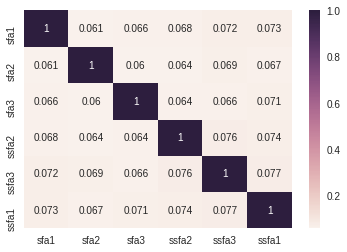

In [221]:
sns.heatmap(mutual_information_scores, annot=True)
plt.savefig('mutual_information_sfa_vs_ssfa')

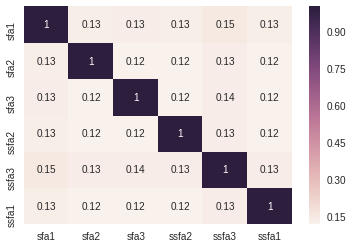

In [239]:
sns.heatmap(correlation, annot=True)
plt.savefig('correlation_sfa_vs_ssfa')

In [237]:
CORR - np.eye(CORR.shape[0])

array([[ -2.22044605e-16,   2.35650240e-02,   9.45479480e-03, ...,
          3.09971123e-02,   1.02257859e-02,   6.29267494e-02],
       [  2.35650240e-02,   0.00000000e+00,   8.91524468e-03, ...,
          1.59738549e-02,   3.91210112e-02,   1.05500551e-01],
       [  9.45479480e-03,   8.91524468e-03,   0.00000000e+00, ...,
          4.01751460e-02,   1.05546837e-02,   2.36349655e-02],
       ..., 
       [  3.09971123e-02,   1.59738549e-02,   4.01751460e-02, ...,
          0.00000000e+00,   5.61961613e-02,   6.81047725e-03],
       [  1.02257859e-02,   3.91210112e-02,   1.05546837e-02, ...,
          5.61961613e-02,   0.00000000e+00,   4.20858409e-02],
       [  6.29267494e-02,   1.05500551e-01,   2.36349655e-02, ...,
          6.81047725e-03,   4.20858409e-02,   0.00000000e+00]])